In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


임의의 time series data 생성

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

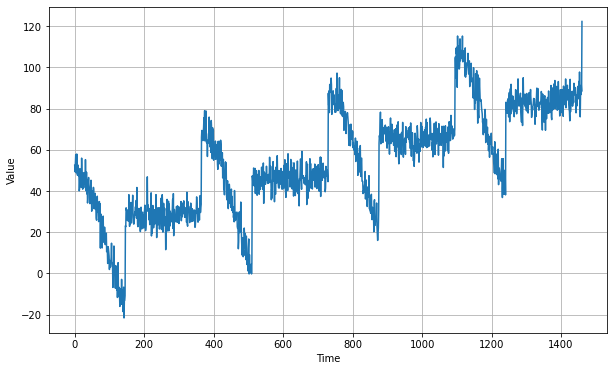

In [3]:
plt.figure(figsize=(10,6))
plot_series(time , series)

In [4]:
# 생성한 데이터를 train 과 valid로 분할
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, 128, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
# callback 함수에서 자동으로 learning rate를 변경하게끔 만들어 줌.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 27.6651 - mae: 28.1627
Epoch 88/100
8/8 [==============================] - 0s 7ms/step - loss: 28.1057 - mae: 28.6024
Epoch 89/100
8/8 [==============================] - 0s 6ms/step - loss: 25.0099 - mae: 25.5036
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 29.2331 - mae: 29.7304
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 39.5661 - mae: 40.0657
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 20.2192 - mae: 20.7125
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 42.4172 - mae: 42.9140
Epoch 94/100
8/8 [==============================] - 0s 9ms/step - loss: 46.5167 - mae: 47.0166
Epoch 95/100
8/8 [==============================] - 0s 7ms/step - loss: 50.0829 - mae: 50.5817
Epoch 96/100
8/8 [==============================] - 0s 7ms/step - loss: 57.1794 - mae: 57.6787
Epoch 97/100
8/8 [==============================] - 0s 7ms/step

learning rate 와 loss의 그래프를 보면
loss가 가장 작아질때의 lr을 구할 수 있다.
여기선 대략 5*e-6

(1e-08, 0.001, 0.0, 300.0)

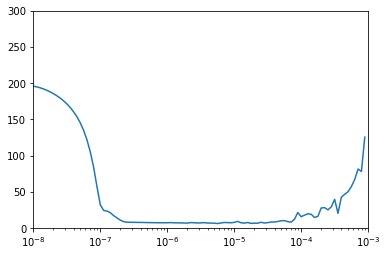

In [13]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [15]:
#최적의 lr을 적용해서 다시 트레이닝
dataset = windowed_dataset(x_train, window_size, 128, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=0)

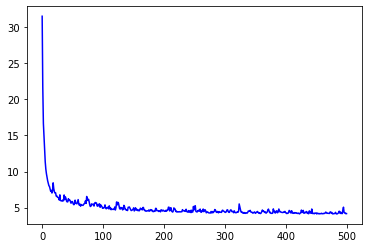

In [16]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

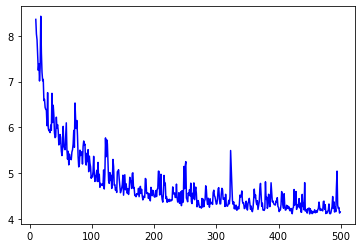

In [17]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [18]:
forecast = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


In [19]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


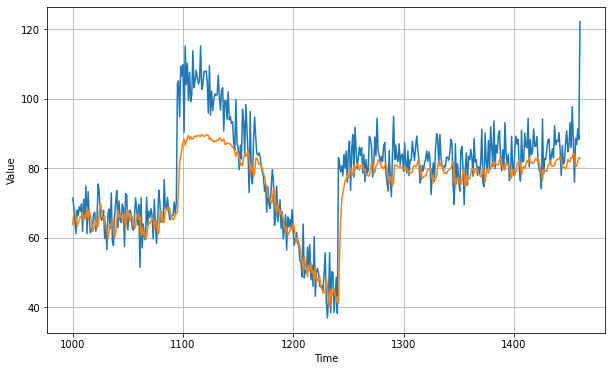

In [20]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.2507534

<Figure size 432x288 with 0 Axes>

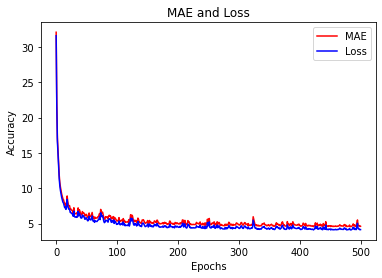

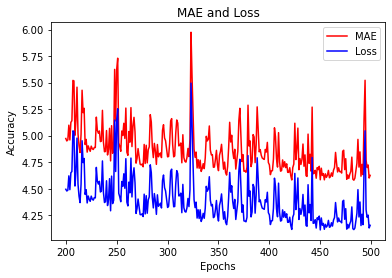

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()